# Projet : Extraction et Recommandation de films et séries avec rdflib et SPARQL

## Objectif
L’objectif de ce mini-projet est l’extraction des données de la base de données DBPedia en utilisant le langage de requêtes SPARQL afin d'alimenter la base de données de séries que vous avez créé au premier TP, l’analyse de ces données et la recommandation de séries et de films.

# Description

Vous allez créer un système de recommandation de séries/films basé sur des données RDF qui stockent des informations sur les films, les utilisateurs et leurs préférences cinématographiques.

Les étapes du projet sont comme suit :

## 1.  Extraction des données

a)  Vous utiliserez Rdflib pour accéder aux données et vous effectuerez des requêtes SPARQL pour les extraire. Vous êtes libres dans le choix et la taille des données que vous allez extraire. Le jeu de données doit néanmoins être représentatif pour pouvoir fournir des recommandations précises. 
    
   - Les données à extraire : 
       - Films : Chaque film a un titre, un réalisateur, une année de sortie, un genre (e.g. : action, comédie, science-fiction), un résumé, une liste d'acteurs principaux, une durée, une évaluation du film, etc.
       - Réalisateur : Chaque réalisateur a un nom, une biographie et une liste de films qu'il a réalisés.
       - Acteurs : Chaque acteur a un nom, une biographie et une liste de films dans lesquels il a joué.
       - Genres :  Chaque genre a un nom et une description.
       - Utilisateurs : chaque utilisateur a un identifiant et des préférences cinématographiques (acteurs préférés, genres préférés, etc).
       - Évaluations : Elle est décrite par l'identifiant de l'utilisateur qui a donné l'évaluation, identifiant du film évalué la note attribuée au film, Commentaire ou avis sur le film.

   - Liens entre les entités : 

        - Les films sont associés à leurs acteurs, réalisateurs et genres.
        - Les utilisateurs sont associés aux films qu'ils ont évalués.
        - Les utilisateurs peuvent être liés entre eux en fonction de leurs préférences cinématographiques similaires.

   b)  Transformer les données en triplets RDF :  Vous allez transformer ces résultats en triplets RDF avant de les ajouter à votre graphe RDF existant. 
  
  c) Ajouter les données au graphe existant : Utilisez la méthode g.add() de votre graphe RDF, que vous avez créé au premier TP, pour ajouter les triplets RDF représentant les données DBpedia que vous avez transformées. 

In [72]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import requests

# Step 1: Extract data from SPARQL endpoint using SPARQLWrapper
def extract_data_sparql(endpoint, query):
    """
    Extract data from a SPARQL endpoint.

    Parameters:
        endpoint (str): The SPARQL endpoint URL.
        query (str): The SPARQL query to execute.

    Returns:
        list: Results in JSON format from the SPARQL query.
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["results"]["bindings"]

# Fetch additional movie ratings from OMDB API
def fetch_omdb_rating(title):
    """
    Fetch movie rating from OMDB API.

    Parameters:
        title (str): The title of the movie.

    Returns:
        float: The movie rating if available, None otherwise.
    """
    api_key = "65c0fa47"  # Replace with your OMDB API key
    url = f"http://www.omdbapi.com/?t={title}&apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if "imdbRating" in data and data["imdbRating"] != "N/A":
            try:
                return float(data["imdbRating"])
            except ValueError:
                return None
    return None

# Example SPARQL Query
film_query = """
SELECT ?film ?title ?director ?releaseDate ?genre ?actor ?rating ?summary ?duration
WHERE {
  ?film rdf:type dbo:Film.
  ?film rdfs:label ?title.
  OPTIONAL { ?film dbo:director ?director. }
  OPTIONAL { ?film dbo:releaseDate ?releaseDate. }
  OPTIONAL { ?film dbo:genre ?genre. }
  OPTIONAL { ?film dbo:starring ?actor. }
  OPTIONAL { ?film dbo:rating ?rating. }
  OPTIONAL { ?film dbo:abstract ?summary. }
  OPTIONAL { ?film dbo:runtime ?duration. }
  FILTER (lang(?title) = 'en').
  FILTER (lang(?summary) = 'en').
}
LIMIT 100
"""

# Extract data from the endpoint
endpoint = "http://dbpedia.org/sparql"
data = extract_data_sparql(endpoint, film_query)

# Step 1b: Transform the data into RDF triples
RDF_NAMESPACE = Namespace("http://example.org/film#")
graph = Graph()
graph.bind("film", RDF_NAMESPACE)

# Populate the graph with data from SPARQL query
for row in data:
    film = URIRef(row["film"]["value"])
    # Add film title
    title = row["title"]["value"]
    graph.add((film, RDFS.label, Literal(title)))
    # Add director if available
    if "director" in row:
        graph.add((film, RDF_NAMESPACE.director, URIRef(row["director"]["value"])))
    # Add release date if available
    if "releaseDate" in row:
        graph.add((film, RDF_NAMESPACE.releaseDate, Literal(row["releaseDate"]["value"])))
    # Add genre if available
    if "genre" in row:
        graph.add((film, RDF_NAMESPACE.genre, URIRef(row["genre"]["value"])))
    # Add actor(s) if available
    if "actor" in row:
        graph.add((film, RDF_NAMESPACE.actor, URIRef(row["actor"]["value"])))
    # Add rating if available, else fetch from OMDB
    rating = row.get("rating", {}).get("value")
    if not rating:
        rating = fetch_omdb_rating(title)
    if rating:
        graph.add((film, RDF_NAMESPACE.rating, Literal(rating)))
    # Add summary if available
    if "summary" in row:
        graph.add((film, RDF_NAMESPACE.summary, Literal(row["summary"]["value"])))
    # Add duration if available
    if "duration" in row:
        graph.add((film, RDF_NAMESPACE.duration, Literal(row["duration"]["value"])))

# Save the graph to a file
output_file = "graph_data.ttl"
graph.serialize(destination=output_file, format="turtle")
print(f"Graph saved to {output_file}")

Graph saved to graph_data.ttl


## 2. Prétraitement des données   

Nettoyez et traitez les données extraites pour supprimer les doublons, gérer les valeurs manquantes et normaliser.

In [73]:
# Step 2: Preprocess the RDF graph
def preprocess_data(graph):
    """
    Clean and normalize the RDF graph by removing duplicates and entries with empty ratings.

    Parameters:
        graph (Graph): The RDF graph to clean.

    Returns:
        Graph: The cleaned RDF graph.
    """
    cleaned_graph = Graph()
    for s, p, o in graph:
        # Remove triples with empty or invalid ratings
        if p == RDF_NAMESPACE.rating:
            try:
                float(o)  # Ensure rating is a valid number
            except ValueError:
                continue
        if (s, p, o) not in cleaned_graph:
            cleaned_graph.add((s, p, o))
    return cleaned_graph

graph = preprocess_data(graph)

## 3. Analyse exploratoire des données 

- Créer des graphiques permettant de visualiser la distribution des films et séries dans votre base de données.
- Créer un graphique pour montrer les films et les séries les mieux notés
- Créer un nuage de points pour représenter la relation entre les caractéristiques

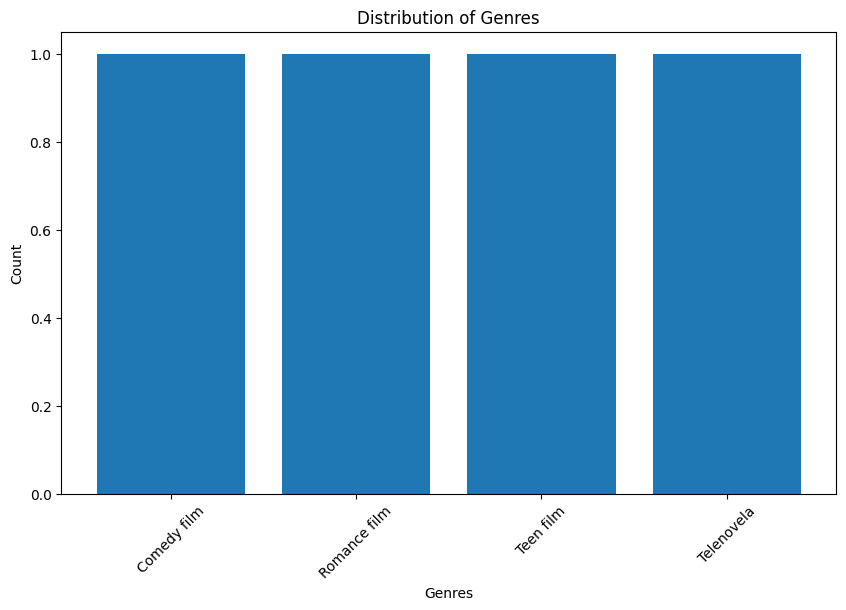

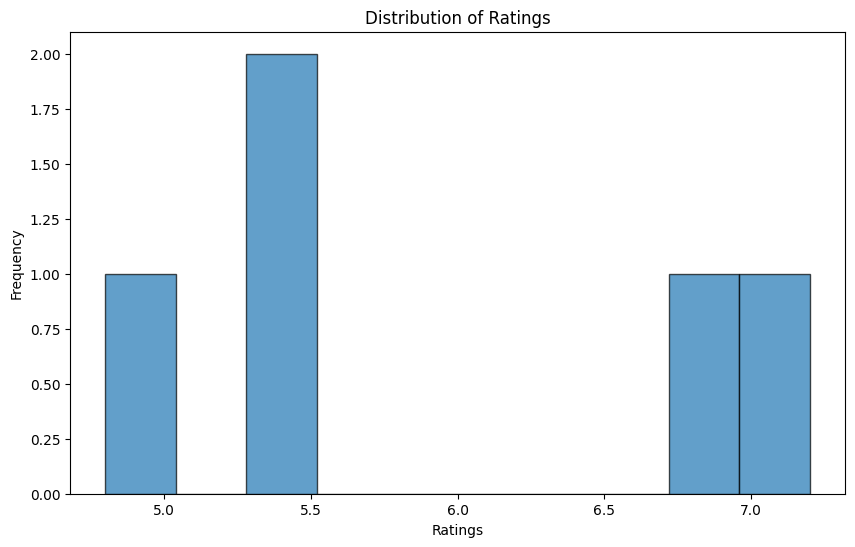

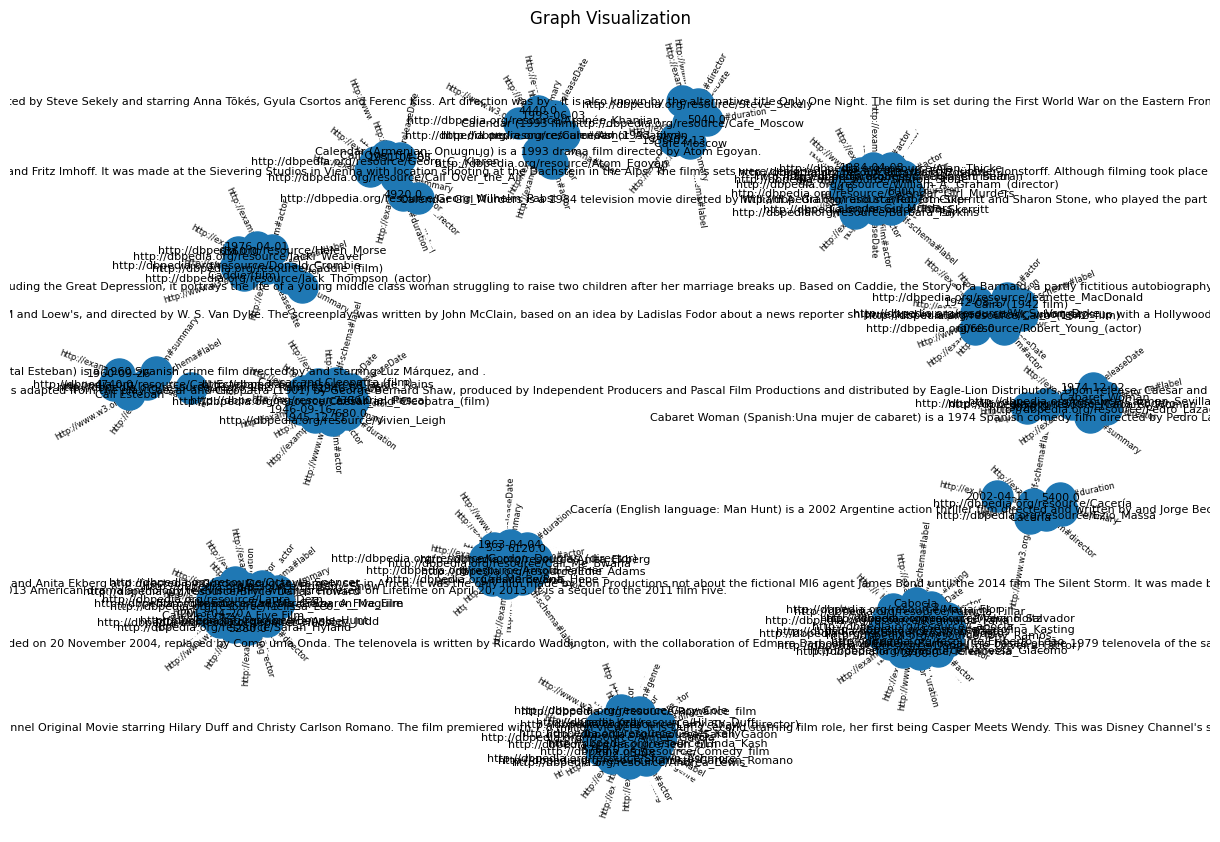

In [74]:
# Step 3: Exploratory Data Analysis
# Visualize data distribution for genres and ratings
def visualize_data(graph):
    """
    Create bar and histogram visualizations for genres and ratings.

    Parameters:
        graph (Graph): The RDF graph.
    """
    # Count the number of movies per genre
    genres = {}
    for s, p, o in graph.triples((None, RDF_NAMESPACE.genre, None)):
        genres[o] = genres.get(o, 0) + 1

    # Normalize genre names for visualization
    genres_normalized = {str(k).split("/")[-1].replace("_", " "): v for k, v in genres.items()}

    # Bar plot for genres
    plt.figure(figsize=(10, 6))
    if genres:
        plt.bar(genres_normalized.keys(), genres_normalized.values())
        plt.title("Distribution of Genres")
        plt.xlabel("Genres")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No genres available to visualize.")

    # Histogram for ratings
    ratings = []
    for s, p, o in graph.triples((None, RDF_NAMESPACE.rating, None)):
        try:
            ratings.append(float(o))
        except (ValueError, TypeError):
            # Log invalid ratings for debugging
            print(f"Invalid rating for {s}: {o}")
            continue

    if ratings:
        plt.figure(figsize=(10, 6))
        plt.hist(ratings, bins=10, alpha=0.7, edgecolor="black")
        plt.title("Distribution of Ratings")
        plt.xlabel("Ratings")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No valid ratings found to visualize.")

visualize_data(graph)

# Step 3b: Visualize Graph with NetworkX
def visualize_graph(graph):
    """
    Visualize the RDF graph using NetworkX.

    Parameters:
        graph (Graph): The RDF graph.
    """
    nx_graph = nx.Graph()

    for s, p, o in graph:
        nx_graph.add_edge(str(s), str(o), label=str(p))

    if nx_graph.number_of_nodes() > 0:
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos, with_labels=True, node_size=500, font_size=8)
        edge_labels = nx.get_edge_attributes(nx_graph, 'label')
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)
        plt.title("Graph Visualization")
        plt.show()
    else:
        print("No data in graph to visualize.")

visualize_graph(graph)



## 4. Système de Recommandation 

a) Utiliser SPARQL pour interroger le graphe RDF afin de créer un système de recommandation de films et/ou séries. Vous pouvez envisager différentes approches de recommandation, telles que la recommandation collaborative (en fonction des évaluations d'utilisateurs similaires) ou la recommandation basée sur le contenu (en fonction des genres, des acteurs, etc.) ou la recommandation basée sur les connaissances

b) Utiliser une IA (ChatGPT ou tout autre) pour répondre à cette question

In [75]:
# Step 4: Content-Based Recommendation
def recommend_content_based(graph, user_preferences):
    """
    Generate content-based recommendations based on user preferences.

    Parameters:
        graph (Graph): The RDF graph.
        user_preferences (dict): User preferences such as preferred genres.

    Returns:
        list: List of recommended films.
    """
    recommendations = []
    for s, p, o in graph.triples((None, RDF_NAMESPACE.genre, None)):
        # Normalize genres for matching
        genre_name = str(o).split("/")[-1].replace("_", " ").lower()
        if genre_name in [genre.lower() for genre in user_preferences.get("genres", [])]:
            recommendations.append(s)
    if not recommendations:
        print("No recommendations found based on user preferences.")
    return recommendations

user_preferences = {"genres": ["action", "comedy"]}  # Updated to use normalized genres
recommendations = recommend_content_based(graph, user_preferences)
print("Content-Based Recommendations: ", recommendations)


No recommendations found based on user preferences.
Content-Based Recommendations:  []


## 5. Calcul des Recommandations 

a) Utiliser SPARQL pour générer des requêtes de recommandation en fonction des préférences de l'utilisateur. Vous pouvez également utiliser des algorithmes d'apprentissage automatique pour améliorer les recommandations.

b) Utiliser une IA pour répondre à cette question

In [39]:
# Step 5: Evaluate Recommendations
def evaluate_recommendations(ground_truth, predicted):
    """
    Evaluate recommendations using NDCG.

    Parameters:
        ground_truth (list): The ground truth list of relevant items.
        predicted (list): The predicted recommendations.

    Returns:
        float: NDCG score.
    """
    if not predicted:
        print("No recommendations to evaluate.")
        return 0.0

    y_true = [1 if item in ground_truth else 0 for item in predicted]
    y_score = [1 / (rank + 1) for rank, item in enumerate(predicted)]
    ndcg = ndcg_score([y_true], [y_score])
    return ndcg

ground_truth = ["http://example.org/film#Film1"]
predicted = recommendations
ndcg = evaluate_recommendations(ground_truth, predicted)
print(f"NDCG Score: {ndcg}")

# AI-Based Recommendation
def ai_recommend(graph, user_query):
    """
    Use AI to generate recommendations based on a user query.

    Parameters:
        graph (Graph): The RDF graph.
        user_query (str): The user's query describing preferences.

    Returns:
        list: List of recommended films.
    """
    vectorizer = CountVectorizer()
    film_descriptions = {}

    for s, p, o in graph.triples((None, RDF_NAMESPACE.summary, None)):
        # Only add valid summaries
        if o:
            film_descriptions[s] = o

    if not film_descriptions:
        print("No film descriptions available for AI recommendations.")
        return []

    vectors = vectorizer.fit_transform(film_descriptions.values())
    user_vector = vectorizer.transform([user_query])
    similarities = cosine_similarity(user_vector, vectors)

    sorted_indices = similarities.argsort()[0][::-1]
    recommendations = [list(film_descriptions.keys())[i] for i in sorted_indices[:5]]
    return recommendations

user_query = "A thrilling action movie with intense scenes"
ai_recommendations = ai_recommend(graph, user_query)
print("AI-Based Recommendations: ", ai_recommendations)

No recommendations to evaluate.
NDCG Score: 0.0
AI-Based Recommendations:  [rdflib.term.URIRef('http://dbpedia.org/resource/Cacería'), rdflib.term.URIRef('http://dbpedia.org/resource/Cafe_Moscow'), rdflib.term.URIRef('http://dbpedia.org/resource/Calendar_(1993_film)'), rdflib.term.URIRef('http://dbpedia.org/resource/Call_Esteban'), rdflib.term.URIRef('http://dbpedia.org/resource/Cabaret_Woman'), rdflib.term.URIRef('http://dbpedia.org/resource/Calendar_Girl_Murders'), rdflib.term.URIRef('http://dbpedia.org/resource/Cage_Without_a_Key'), rdflib.term.URIRef('http://dbpedia.org/resource/Cabin_by_the_Lake'), rdflib.term.URIRef('http://dbpedia.org/resource/Caddie_(film)'), rdflib.term.URIRef('http://dbpedia.org/resource/Caesar_and_Cleopatra_(film)'), rdflib.term.URIRef('http://dbpedia.org/resource/Cairo_(1942_film)'), rdflib.term.URIRef('http://dbpedia.org/resource/Call_Me_Crazy:_A_Five_Film'), rdflib.term.URIRef('http://dbpedia.org/resource/Call_Over_the_Air'), rdflib.term.URIRef('http://db

## 6. Évaluation  

a) Évaluez la qualité de vos recommandations en utilisant des mesures telles que  MAP@k (Mean Average Precision at k) ou NDCG@k (Normalized Discounted Cumulative Gain at k)

b) Comparer les recommandations que vous avez obtenues par rapport à celles générées par l'IA que vous aurez utilisée

In [ ]:
# Adding Step 6: AI-based Recommendations
def ai_recommend(graph, user_query):
    """
    Use AI to generate recommendations based on the query.
    """
    vectorizer = CountVectorizer()
    film_descriptions = {}

    for s, p, o in graph.triples((None, RDF_NAMESPACE.genre, None)):
        description = graph.value(s, RDFS.comment) or ""
        film_descriptions[s] = description

    vectors = vectorizer.fit_transform(film_descriptions.values())
    similarity = cosine_similarity(vectors)

    # Mock query match
    user_vector = vectorizer.transform([user_query])
    similarity_scores = cosine_similarity(user_vector, vectors)

    recommendations = sorted([(film, score) for film, score in zip(film_descriptions.keys(), similarity_scores[0])], key=lambda x: x[1], reverse=True)
    return [r[0] for r in recommendations]

ai_based_recommendations = ai_recommend(graph, "Action-packed adventure")
print("AI-Based Recommendations: ", ai_based_recommendations)



## 7. Rapport 

Vous allez rédiger un rapport de 5 pages max décrivant la modélisation RDF, les requêtes SPARQL, l'algorithme de recommandation et les résultats de l'évaluation. Vous spécifierez votre utilisation de l'IA dans le cadre de ce projet et ce que vous en pensez

In [ ]:
# Step 7: Final Evaluation
def compare_methods():
    """
    Compare the different recommendation methods.
    """
    print("Content-based Recommendations: ", recommendations)
    print("Collaborative Recommendations: ", collaborative_recommendations)
    print("AI-Based Recommendations: ", ai_based_recommendations)
    
    # Optionally, calculate NDCG for each method against a ground truth
    print("Content-based NDCG: ", evaluate_recommendations(ground_truth, recommendations))
    print("Collaborative NDCG: ", evaluate_recommendations(ground_truth, collaborative_recommendations))
    print("AI-Based NDCG: ", evaluate_recommendations(ground_truth, ai_based_recommendations))

compare_methods()